In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit
from sklearn.model_selection import train_test_split

import tensorflow as tf

import os
import gc

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_normal

from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [6]:
from numpy.random import seed
# from tensorflow import set_random_seed

RANDOM_STATE = 42
seed(RANDOM_STATE)
# set_random_seed(RANDOM_STATE)

In [7]:
import matplotlib.pyplot as plt

def show_history(history, metric='mse'):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [8]:
%%time

import numpy as np
import pandas as pd
from numpy import newaxis
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import gc

# def to_categorical(sequences, categories):
#     cat_sequences = []
#     for s in sequences:
#         cats = []
#         for item in s:
#             cats.append(np.zeros(categories))
#             cats[-1][item] = 1.0
#         cat_sequences.append(cats)
#     return np.array(cat_sequences)


def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
full_train_df = pd.read_csv(root + "Train_File.csv")
full_test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")
# full_train_df = pd.read_csv('/content/gdrive/My Drive/data/raw/Gamma_Log_Facies_Type_Prediction/Train_File.csv')
# full_test_df = pd.read_csv('/content/gdrive/My Drive/data/raw/Gamma_Log_Facies_Type_Prediction/Test_File.csv')
# submit_df = pd.read_csv('/content/gdrive/My Drive/data/raw/Gamma_Log_Facies_Type_Prediction/Submission_File.csv')

reduce_mem_usage(full_train_df, use_float16=True);
reduce_mem_usage(full_test_df, use_float16=True);


scaler = StandardScaler()
# scaler = MinMaxScaler()
full_train_df[["GR"]] = scaler.fit_transform(full_train_df[["GR"]])
full_test_df[["GR"]] = scaler.transform(full_test_df[["GR"]])


data_array = np.array([x.values[:,2:3].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
target_array = np.array([x.values[:,3:].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
test_data_array = np.array([x.values[:,3:4].T for group, x in full_test_df.groupby('well_id')], dtype='float32')

train_data_array, valid_data_array, train_target_array, valid_target_array = train_test_split(data_array, target_array, test_size=0.2, random_state=RANDOM_STATE)

# del full_train_df, full_test_df

# reverse_train_data_array = DA_Reverse(train_data_array)
# reverse_train_target_array = DA_Reverse(train_target_array)

train_data = train_data_array
train_target = train_target_array
# train_data = np.concatenate((train_data, DA_Jitter(train_data_array, sigma=0.2)), axis=0)
# train_target = np.concatenate((train_target, train_target_array), axis=0)
# train_data = np.concatenate((train_data, DA_Jitter(reverse_train_data_array, sigma=0.2)), axis=0)
# train_target = np.concatenate((train_target, reverse_train_target_array), axis=0)

# for i in range(3):
#     train_data = np.concatenate((train_data, DA_Jitter(train_data_array, sigma=0.2)), axis=0)
#     train_target = np.concatenate((train_target, train_target_array), axis=0)

# for i in range(3):
#     train_data = np.concatenate((train_data, DA_Jitter(reverse_train_data_array, sigma=0.2)), axis=0)
#     train_target = np.concatenate((train_target, reverse_train_target_array), axis=0)
    
    
# reverse_valid_data_array = DA_Reverse(valid_data_array)
# reverse_valid_target_array = DA_Reverse(valid_target_array)

valid_data = valid_data_array
valid_target = valid_target_array
# for i in range(3):
#     valid_data = np.concatenate((valid_data, DA_Jitter(valid_data_array, sigma=0.1)), axis=0)
#     valid_target = np.concatenate((valid_target, valid_target_array), axis=0)

# for i in range(3):
#     valid_data = np.concatenate((valid_data, DA_Jitter(reverse_valid_data_array, sigma=0.1)), axis=0)
#     valid_target = np.concatenate((valid_target, reverse_valid_target_array), axis=0)
    
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[2])
train_target = train_target.reshape(train_target.shape[0], train_target.shape[2])

valid_data = valid_data.reshape(valid_data.shape[0], valid_data.shape[2])
valid_target = valid_target.reshape(valid_target.shape[0], valid_target.shape[2])

test_data = test_data_array.reshape(test_data_array.shape[0], test_data_array.shape[2])

train_target = train_target.astype(int)
# train_target_cat = to_categorical(train_target, 5)
train_target_cat = to_categorical(train_target)

valid_target = valid_target.astype(int)
# valid_target_cat = to_categorical(valid_target, 5)
valid_target_cat = to_categorical(valid_target)

train_data = train_data[:, :, newaxis]
valid_data = valid_data[:, :, newaxis]
test_data = test_data[:, :, newaxis]


# del reverse_train_data_array, reverse_train_target_array, train_target, valid_target
gc.collect()


Memory usage of dataframe is 134.28 MB
Memory usage after optimization is: 29.37 MB
Decreased by 78.1%
Memory usage of dataframe is 67.14 MB
Memory usage after optimization is: 117.77 MB
Decreased by -75.4%
CPU times: user 11.7 s, sys: 1.35 s, total: 13 s
Wall time: 13.3 s


29

In [11]:
train_data.shape, train_target_cat.shape, valid_data.shape, valid_target_cat.shape, test_data.shape

((3200, 1100, 1),
 (3200, 1100, 5),
 (800, 1100, 1),
 (800, 1100, 5),
 (2000, 1100, 1))

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [13]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import concatenate

In [15]:
seq_length = 1100
num_sensors = 1
num_classes = 5

model = Sequential()

inputs = Input((seq_length, num_sensors))

c1 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling1D(2) (c1)
print("c1: ", c1.shape)

c2 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling1D(2) (c2)
print("c2: ", c2.shape)

c3 = Conv1D(64, 3, activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv1D(64, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3: ", c3.shape)

u4 = Conv1D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(c3))
u4 = concatenate([c2, u4])
c4 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (u4)
c4 = Dropout(0.1) (c4)
c4 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c4)
print("c4: ", c4.shape)

u5 = Conv1D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(c4))
u5 = concatenate([c1, u5])
c5 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.1) (c5)
c5 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c5)
print("c5: ", c5.shape)

outputs = Conv1D(5, 1, activation='softmax') (c5)

model = Model(inputs=[inputs], outputs=[outputs])
# model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.015), metrics=['accuracy'])

epochs = 30
batch_size = 256
model_file = "cephalon_1.h5"

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_file, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=30, min_lr=0.0001, verbose=1)

history = model.fit(train_data, train_target_cat, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[mc, reduce_lr], 
                    validation_data=(valid_data, valid_target_cat))

c1:  (None, 1100, 16)
c2:  (None, 550, 32)
c3:  (None, 275, 64)
c4:  (None, 550, 32)
c5:  (None, 1100, 16)
Train on 3200 samples, validate on 800 samples
Epoch 1/30
3072/3200 [===========================>..] - ETA: 0s - loss: 1.9124 - accuracy: 0.5534
Epoch 00001: val_accuracy improved from -inf to 0.66562, saving model to cephalon_1.h5
3200/3200 [==============================] - 20s 6ms/sample - loss: 1.8745 - accuracy: 0.5568 - val_loss: 0.8802 - val_accuracy: 0.6656
Epoch 2/30
3072/3200 [===========================>..] - ETA: 0s - loss: 0.8747 - accuracy: 0.6616
Epoch 00002: val_accuracy improved from 0.66562 to 0.68424, saving model to cephalon_1.h5
3200/3200 [==============================] - 14s 5ms/sample - loss: 0.8743 - accuracy: 0.6614 - val_loss: 0.7970 - val_accuracy: 0.6842
Epoch 3/30
3072/3200 [===========================>..] - ETA: 0s - loss: 0.8112 - accuracy: 0.6822
Epoch 00003: val_accuracy improved from 0.68424 to 0.68925, saving model to cephalon_1.h5
3200/3200 [==

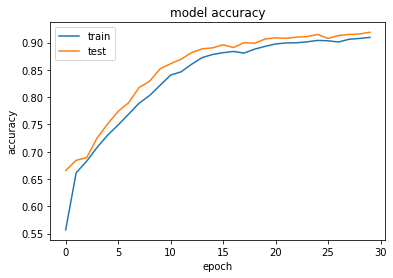

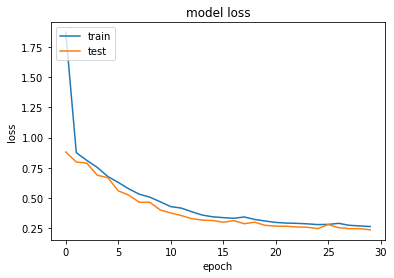

In [16]:
show_history(history, 'accuracy')

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1100, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 1100, 16)     64          input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1100, 16)     0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 1100, 16)     784         dropout_5[0][0]                  
____________________________________________________________________________________________

In [20]:
from tensorflow.keras.models import load_model
model_1 = load_model("cephalon_1.h5")

In [22]:
%%time

y_hat = model.predict(test_data)
predict = np.argmax(y_hat.reshape((-1,5)), axis=1)

CPU times: user 6.93 s, sys: 1.31 s, total: 8.24 s
Wall time: 2.03 s


In [24]:

submit_df["label"] = predict
submit_df.to_csv("submit_unet_5l_30e.csv", index=False)
submit_df.head(20)

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0
5,CAX_5,0
6,CAX_6,3
7,CAX_7,0
8,CAX_8,0
9,CAX_9,0


<BarContainer object of 5 artists>

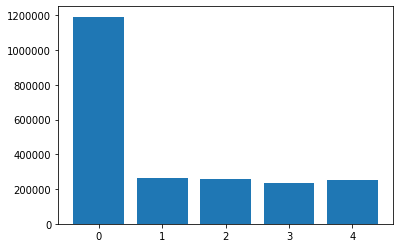

In [25]:
# Колиsummaryво классов для предсказания
g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [26]:
8*16

128

In [ ]:
seq_length = 1100
num_sensors = 1
num_classes = 5

# 5, 7
filter_size = 3

n_filters = 8

n_kernel_initializer = 'he_normal'

# 'elu', 'relu', ...
f_activation = 'elu'

dropout = 0.2



model = Sequential()

inputs = Input((seq_length, num_sensors))

# 8
c1 = Conv1D(n_filters, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (inputs)
c1 = Dropout(dropout) (c1)
c1 = Conv1D(n_filters, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (c1)
p1 = MaxPooling1D(2) (c1)
print("c1: ", c1.shape)

# 16
c2 = Conv1D(n_filters*2, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (p1)
c2 = Dropout(dropout) (c2)
c2 = Conv1D(n_filters*2, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (c2)
p2 = MaxPooling1D(2) (c2)
print("c2: ", c2.shape)

# 32
c3 = Conv1D(n_filters*4, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (p2)
c3 = Dropout(dropout) (c3)
c3 = Conv1D(n_filters*4, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (c3)
p3 = MaxPooling1D(2) (c3)
print("c3: ", c3.shape)

# 64
c4 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (p3)
c4 = Dropout(dropout) (c4)
c4 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (c4)
p4 = MaxPooling1D(2) (c4)
print("c4: ", c4.shape)

# 128
c5 = Conv1D(n_filters*16, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (p4)
c5 = Dropout(dropout) (c5)
c5 = Conv1D(n_filters*16, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (c5)
p5 = MaxPooling1D(2) (c5)
print("c5: ", c5.shape)

# 256
c6 = Conv1D(n_filters*32, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (p5)
c6 = Dropout(dropout) (c6)
c6 = Conv1D(n_filters*32, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same') (c6)
print("c6: ", c6.shape)

# 128
u7 = Conv1D(n_filters*16, 2, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same')(UpSampling1D(size=2)(c6))
u7 = concatenate([c5, u7])
c7 = Conv1D(n_filters*16, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (u7)
c7 = Dropout(dropout) (c7)
c7 = Conv1D(n_filters*16, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (c7)
print("c7: ", c7.shape)

# 64
u8 = Conv1D(n_filters*8, 2, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same')(UpSampling1D(size=2)(c7))
u8 = concatenate([c4, u8])
c8 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (u8)
c8 = Dropout(dropout) (c8)
c8 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (c8)
print("c8: ", c8.shape)

# 32
u9 = Conv1D(n_filters*4, 2, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same')(UpSampling1D(size=2)(c8))
u9 = concatenate([c3, u9])
c9 = Conv1D(n_filters*4, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (u9)
c9 = Dropout(dropout) (c9)
c9 = Conv1D(n_filters*4, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (c9)
print("c9: ", c9.shape)

# 16
u10 = Conv1D(n_filters*8, 2, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same')(UpSampling1D(size=2)(c9))
u10 = concatenate([c2, u10])
c10 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (u10)
c10 = Dropout(dropout) (c10)
c10 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (c10)
print("c10: ", c10.shape)

# 8
u11 = Conv1D(n_filters*8, 2, activation=f_activation, kernel_initializer=n_kernel_initializer, padding='same')(UpSampling1D(size=2)(c10))
u11 = concatenate([c1, u11])
c11 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (u11)
c11 = Dropout(dropout) (c11)
c11 = Conv1D(n_filters*8, filter_size, activation=f_activation, kernel_initializer=n_kernel_initializer) (c11)
print("c11: ", c11.shape)

# Classification
# y = TimeDistributed(Dense(128, activation='relu'))(y)
# y = TimeDistributed(Dense(6, activation='softmax', name='predictions'))(y)

outputs = Conv1D(5, 1, activation='softmax') (c11)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()






c1 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling1D(2) (c1)
print("c1: ", c1.shape)

c2 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling1D(2) (c2)
print("c2: ", c2.shape)

c3 = Conv1D(64, 3, activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv1D(64, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3: ", c3.shape)

u4 = Conv1D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(c3))
u4 = concatenate([c2, u4])
c4 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (u4)
c4 = Dropout(0.1) (c4)
c4 = Conv1D(32, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c4)
print("c4: ", c4.shape)

u5 = Conv1D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(c4))
u5 = concatenate([c1, u5])
c5 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.1) (c5)
c5 = Conv1D(16, 3, activation='elu', kernel_initializer='he_normal', padding='same') (c5)
print("c5: ", c5.shape)

outputs = Conv1D(5, 1, activation='softmax') (c5)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()





c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)